# Drive, github and requirements settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


set Github access token

In [1]:
import os
from google.colab import userdata
github_access_token = userdata.get('GITHUB_TOKEN')
gpt_api_key = userdata.get('GPT_KEY')

# Replace 'your_token_here' with your actual token and 'your_repo_url_here' with your repository URL
os.environ['GITHUB_TOKEN'] = github_access_token
os.environ['GPT_KEY'] = gpt_api_key

repo_url = 'https://github.com/sustaz/NLP_DSA_transparency.git'
modified_url = repo_url.replace('https://', f'https://{os.environ["GITHUB_TOKEN"]}@')

Clone Repository

In [ ]:
!git clone {modified_url}

Set github credentials

In [ ]:
!chmod +x ./NLP_DSA_transparency/bash_commands/set_git_credentials.sh
!./NLP_DSA_transparency/bash_commands/set_git_credentials.sh

Syncronize notebook version

In [ ]:
!cp /content/drive/MyDrive/NLLP/statement_of_reason_llm.ipynb /content/NLP_DSA_transparency/

Add, commit, push code

In [ ]:
!chmod +x ./NLP_DSA_transparency/bash_commands/add_commit_push.sh
!./NLP_DSA_transparency/bash_commands/add_commit_push.sh "update notebook"

[main cdc76e8] update notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite statement_of_reason_llm.ipynb (97%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.03 KiB | 211.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/sustaz/NLP_DSA_transparency.git
   4726450..cdc76e8  main -> main


# Read statements of reason

In [ ]:
import pandas as pd
import os

provider = 'LinkedIn'

# Specify the folder path containing the CSV files
folder_path = f'/content/drive/MyDrive/NLLP/data/{provider}/New_Statements_filtered'

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        # Read the CSV file into a dataframe and append it to the list
        dfs.append(pd.read_csv(file_path))

# Concatenate all the dataframes into a single dataframe
concatenated_df = pd.concat(dfs, ignore_index=True)

In [ ]:
len(concatenated_df['category'])

2000

In [ ]:
import matplotlib.pyplot as plt

# Get the unique values and their counts from the 'category' column
categories = concatenated_df['category'].value_counts()

# Create a figure and axes
fig, ax = plt.subplots()

# Create a table with the categories and counts
table_data = [[category, count] for category, count in categories.items()]
table = ax.table(cellText=table_data, colLabels=['Category', 'Count'], loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(2.2, 2.2)

# Hide the axes
ax.axis('off')

# Save the table as an image
plt.savefig('cute_table.png')


In [ ]:
from sklearn.model_selection import train_test_split

# Group the DataFrame by 'category' and sample 1 rows from each group
df = concatenated_df.groupby('category').apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)

Quali sono gli elementi del df che devo considerare

- source_type : SOURCE_VOLUNTARY e SOURCE_TYPE_OTHER_NOTIFICATION

In [ ]:
df = df[df['decision_ground']!= 'DECISION_GROUND_ILLEGAL_CONTENT']

In [ ]:
statements_of_reason = []

for index, row in df.iterrows():
  statements_of_reason.append((row['uuid'], row['incompatible_content_ground'] + '. ' + row['incompatible_content_explanation'] + '. ' + row['decision_facts'], row['category']))

##Read or store to vectorstore the T&C

In [ ]:
import fitz  # PyMuPDF
import re
from NLP_DSA_transparency.src.text_chunker import split_by_newline_caps

# Open the PDF file
pdf_path = f'/content/drive/MyDrive/NLLP/data/{provider}/{provider.upper()}_T&C_4_DSA.pdf'

pdf_document = fitz.open(pdf_path)
pages = []
texts = []

# Iterate through each page
for page_num in range(pdf_document.page_count):
    page = pdf_document.load_page(page_num)
    text = page.get_text("text")
    texts.append(text)

texts = ''.join(texts)
chunks = split_by_newline_caps(texts)

pdf_document.close()

Embedding T&C

In [ ]:
chunks[1]

' Guest reviews standards\nEach review score is between 1 and 10. To get the overall score that you see on Booking.com, we add up\nall the review scores we’ve received and divide that total by the number of received review scores.\nIn addition, guests can give separate ‘subscores’ for specific travel experience aspects, such as location,\ncleanliness, staff, comfort, facilities, value for money and free Wi-Fi. Note that guests submit their\nsubscores and their overall scores independently, so there’s no direct link between them.\nYou can review an accommodation that you booked through Booking.com if you stayed there or if you\narrived at the accommodation but didn’t actually stay there. To edit a review you’ve already submitted,\nplease contact our Customer Service team.\nWe have people and automated systems that specialise in detecting fake reviews submitted to\nBooking.com. If we find any, we delete them and, if necessary, take action against whoever is responsible.\nAnyone who spots

In [ ]:
import voyageai

vo = voyageai.Client(api_key)

EMD_MODEL_SIZE = 1024
COLLECTION_NAME = "voyage-2-law"
model_rag="voyage-law-2"
db_create = False # Set to true if you want to create a vector store, false if it is already created

#from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_voyageai import VoyageAIEmbeddings
from langchain.schema import Document

embeddings = VoyageAIEmbeddings(model=model_rag,
                              voyage_api_key="",
                              show_progress_bar=True)

db_path = f'/content/drive/MyDrive/NLLP/db/{provider}_t&c'

if db_create == True:
  #documents = []

  #for chunk in chunks:
    #documents.append("\n".join(page))


  # Assuming 'pages' is your list of strings
  documents = [Document(page_content=page) for page in chunks]
  vectorstore = Chroma.from_documents(
      collection_name = COLLECTION_NAME,
      persist_directory = db_path,
      documents = documents,
      embedding = embeddings,
      collection_metadata={"hnsw:space": "cosine"})
else:

  vector_db = Chroma(
      collection_name = COLLECTION_NAME,
      persist_directory = db_path,
      embedding_function = embeddings
  )

batch size None


In [ ]:
vector_db.get()['documents'][9]

" Nudity and adult content\nLast updated: 2 years ago\nWe remove content containing nudity or sexual activity.\nExamples of nudity and adult content\n\u200b\nSexually gratifying content, including pornography, simulated sex acts, erotic\nliterature, and other graphic depictions of sex acts performed alone or with\nothers\n\u200b\nImplied sex acts are activities that indicated by inference, association, or\nconsequence rather than by direct depiction\n\u200b\nFull adult nudity or exposure of intimate body parts, including visible genitalia,\nbuttocks, and breasts (excluding breastfeeding)\nDo not share material depicting nudity or sexual activity. We don’t allow content that depicts\nexposed human genitalia, female breasts, and/or human buttocks. We also don’t allow content\nthat depicts, describes, or facilitates access to sexually gratifying material. Content that depicts\nsexual activity is prohibited. Instances of Adult nudity that align with topics relevant to\nprofessional convers

# Plot Providers categories

In [ ]:
from NLP_DSA_transparency.src.utils import *

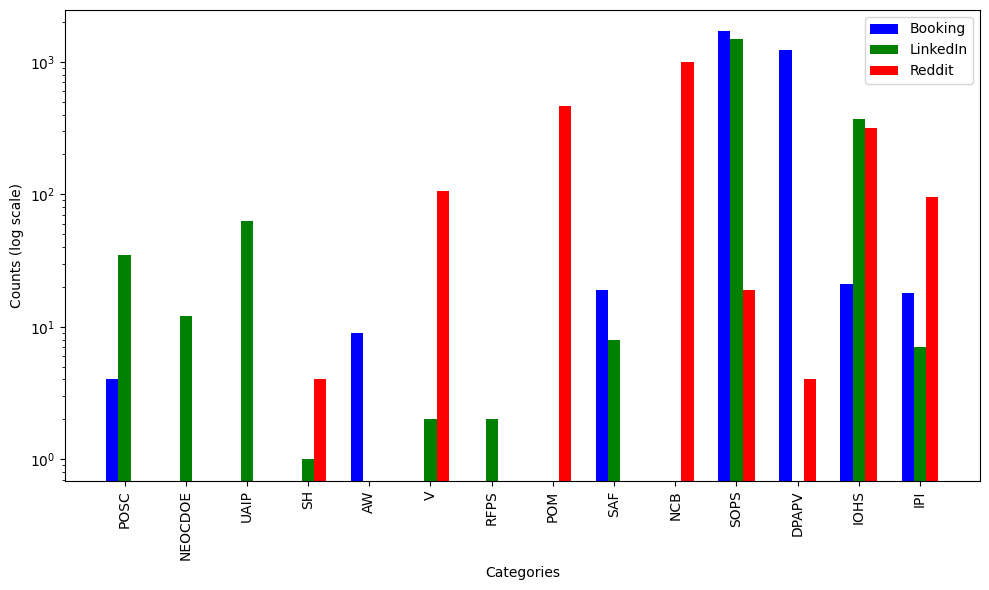

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import os
import numpy as np

Booking = read_files_to_df('/content/drive/MyDrive/NLLP/data/Booking/New_Statements_filtered')
LinkedIn = read_files_to_df('/content/drive/MyDrive/NLLP/data/LinkedIn/New_Statements_filtered')
Reddit = read_files_to_df('/content/drive/MyDrive/NLLP/data/Reddit/New_Statements_filtered')

# Get category counts for each dataframe
booking_counts = Booking['category'].value_counts()
linkedin_counts = LinkedIn['category'].value_counts()
reddit_counts = Reddit['category'].value_counts()

# Combine the data into a single DataFrame
categories = list(set(Booking['category'].unique()) | set(LinkedIn['category'].unique()) | set(Reddit['category'].unique()))

combined_counts = pd.DataFrame({
    'Booking': booking_counts.reindex(categories, fill_value=0),
    'LinkedIn': linkedin_counts.reindex(categories, fill_value=0),
    'Reddit': reddit_counts.reindex(categories, fill_value=0)
}).fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.2
index = np.arange(len(categories))

# Plot bars for each category
booking_bars = ax.bar(index - bar_width, combined_counts['Booking'], bar_width, label='Booking', color='b')
linkedin_bars = ax.bar(index, combined_counts['LinkedIn'], bar_width, label='LinkedIn', color='g')
reddit_bars = ax.bar(index + bar_width, combined_counts['Reddit'], bar_width, label='Reddit', color='r')
acronyms = [create_acronym(category) for category in categories]

# Rotate x-axis labels to vertical
ax.set_xticks(index)
ax.set_xticklabels(acronyms, rotation=90)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Counts (log scale)')
ax.legend()

# Show plot
plt.tight_layout()
#plt.show()
plt.savefig('/content/drive/MyDrive/NLLP/plots/logaritmic_distribution.png')

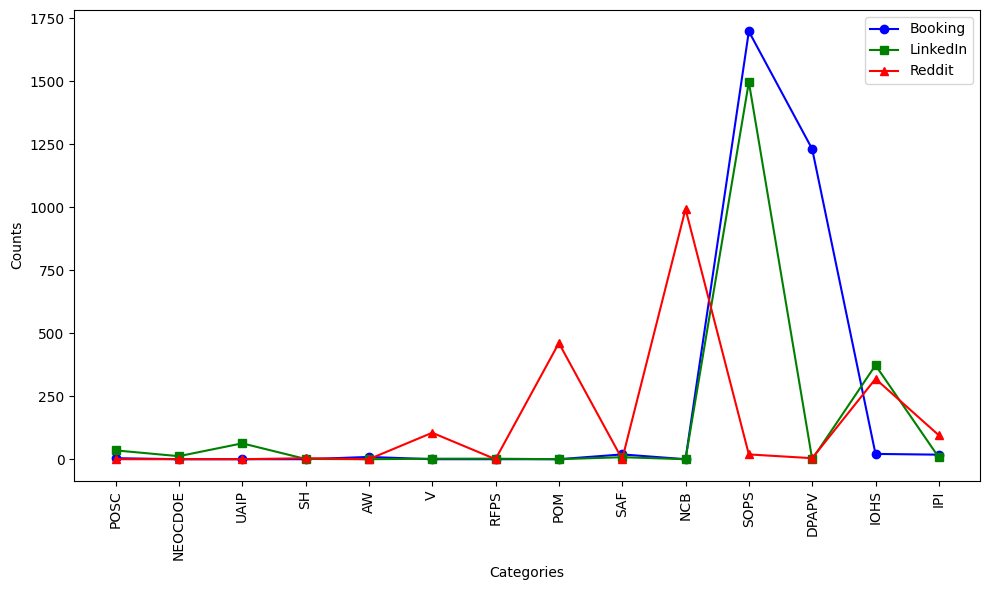

In [ ]:
booking_counts = Booking['category'].value_counts()
linkedin_counts = LinkedIn['category'].value_counts()
reddit_counts = Reddit['category'].value_counts()

# Combine the data into a single DataFrame
categories = list(set(Booking['category'].unique()) | set(LinkedIn['category'].unique()) | set(Reddit['category'].unique()))
combined_counts = pd.DataFrame({
    'Booking': booking_counts.reindex(categories, fill_value=0),
    'LinkedIn': linkedin_counts.reindex(categories, fill_value=0),
    'Reddit': reddit_counts.reindex(categories, fill_value=0)
}).fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define x-axis positions for categories
index = np.arange(len(categories))

# Plot lines for each dataframe
ax.plot(index, combined_counts['Booking'], marker='o', label='Booking', color='b')
ax.plot(index, combined_counts['LinkedIn'], marker='s', label='LinkedIn', color='g')
ax.plot(index, combined_counts['Reddit'], marker='^', label='Reddit', color='r')

# Rotate x-axis labels to vertical
ax.set_xticks(index)
ax.set_xticklabels(acronyms, rotation=90)

# Add labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.legend()

# Show plot
plt.tight_layout()
#plt.show()
plt.savefig('/content/drive/MyDrive/NLLP/plots/inscale_distribution.png')

# Pipeline

In [ ]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd

def bm25_similarity(query, corpora_tec_df):

  # Preprocess the text: tokenization
  def preprocess(text):
      return [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]

  # Tokenize the corpora
  tokenized_corpora = corpora_tec_df['sections'].apply(preprocess).tolist()

  # Initialize the BM25 model
  bm25 = BM25Okapi(tokenized_corpora)

  # Preprocess the query text
  tokenized_query = preprocess(query)

  # Calculate BM25 scores for the query
  scores = bm25.get_scores(tokenized_query)

  # Find the most similar corpus
  most_similar_idx = scores.argmax()
  most_similar_corpus = corpora_tec_df['sections'].iloc[most_similar_idx]

  return most_similar_corpus, scores[most_similar_idx]

In [ ]:
#from unsloth import FastLanguageModel
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
from transformers.generation import GenerationConfig


max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = torch.float16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth


#model_name = "neuralmagic/Meta-Llama-3.1-8B-Instruct-quantized.w8a16"
#model_name =  "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit"

"""model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

model = model.eval()"""

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True
).eval()

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [ ]:
import openai
from openai import OpenAI

def get_gpt_inference(prompt, api_key, model="gpt-4o"):
    """
    Calls the OpenAI GPT API to generate a response to the given prompt.

    Parameters:
    - prompt (str): The prompt to send to the GPT model.
    - model (str): The model to use for the inference (default is "gpt-4").
    - max_tokens (int): The maximum number of tokens to generate in the response (default is 150).

    Returns:
    - str: The generated response from the GPT model.
    """
    client = OpenAI(api_key=api_key)

    completion = client.chat.completions.create(
      model=model,
      messages=[
        #{"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
      ]
    )

    return completion.choices[0].message.content

from docx import Document

def write_text_to_docx(text, file_path):
    """
    Write the given text to a .docx file.

    :param text: The text to write to the file.
    :param file_path: The path to the .docx file.
    """
    # Create a new Document
    doc = Document()

    # Add text to the document
    doc.add_paragraph(text)

    # Save the document to the specified file path
    doc.save(file_path)

In [ ]:
from google.colab import userdata
from NLP_DSA_transparency.src.prompts import *

model_pipeline = 'HuggingFace'
model_engine = 'gpt-4o-mini'
os.makedirs(f'/content/drive/MyDrive/NLLP/outputs/{model_openai}/3_providers_test_2/{provider}/', exist_ok = True)
sections_list = vector_db.get()['documents']
corpora_df_tec = pd.DataFrame(sections_list, columns = ['sections'])
gpt_api_key = userdata.get('GPT_NLLP_KEY')


for idx, statement in enumerate(statements_of_reason):

    top_sim = vector_db.similarity_search_with_relevance_scores(
        query = statement[1],
        k =  2
    )

    corpuses_sim = []
    for top in top_sim:
      corpus_sim, score_sim = top
      corpuses_sim.append(corpus_sim.page_content + ' SEP ')

    top_corpus_sim = ' '.join(corpuses_sim)

    top_corpus_bm25, top_score_bm25 = bm25_similarity(statement[1], corpora_df_tec)

    if top_corpus_sim == top_corpus_bm25:
      top_corpus = top_corpus_sim
    else:
      top_corpus = top_corpus_sim + ' ' + top_corpus_bm25

    if model_pipeline == 'HuggingFace':

      refine_prompt = build_refine_tec(statement[1], top_corpus)
      inputs = tokenizer([refine_prompt], return_tensors = "pt").to("cuda")
      outputs = model.generate(**inputs, use_cache = True)
      response = tokenizer.batch_decode(outputs)[0]

      refined_tec = response.split(refine_prompt)[1]

      prompt = build_prompt(statement[1], refined_tec)
      inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
      outputs = model.generate(**inputs, use_cache = True)
      response = tokenizer.batch_decode(outputs)[0]

      final_output = response.split(prompt)[1]

      generation_log = "INPUT \n" + statement[1] + "\n TOP SIMILARITY : \n" + top_corpus_sim + "TOP BM25 : " + top_corpus_bm25 + "\n \nOUTPUT REFINED T&C\n" + refined_tec
      write_text_to_docx(generation_log, f'/content/drive/MyDrive/NLLP/outputs/{model_engine}/3_providers_test_2/{provider}/{statement[0]}_log.docx')

      generated_response = "INPUT \n" + statement[1] + "\n \nOUTPUT REFINED T&C\n" + refined_tec + '\n FINAL RESPONSE' + final_output
      write_text_to_docx(generated_response, f'/content/drive/MyDrive/NLLP/outputs/{model_engine}/3_providers_test_2/{provider}/{statement[0]}.docx')


    elif model_pipeline == 'GPT':

      refine_prompt = build_refine_tec(statement[1], top_corpus)
      refined_tec = get_gpt_inference(refine_prompt, gpt_api_key, model_engine)

      prompt = build_prompt(statement[1], refined_tec)
      final_output = get_gpt_inference(prompt, gpt_api_key, model_engine)

      generation_log = "INPUT \n" + statement[1] + "\n TOP SIMILARITY : \n" + top_corpus_sim + "TOP BM25 : " + top_corpus_bm25 + "\n \nOUTPUT REFINED T&C\n" + refined_tec
      write_text_to_docx(generation_log, f'/content/drive/MyDrive/NLLP/outputs/{model_engine}/3_providers_test_2/{provider}/{statement[0]}_log.docx')

      generated_response = "INPUT \n" + statement[1] + "\n \nOUTPUT REFINED T&C\n" + refined_tec + '\n FINAL RESPONSE' + final_output
      write_text_to_docx(generated_response, f'/content/drive/MyDrive/NLLP/outputs/{model_engine}/3_providers_test_2/{provider}/{statement[0]}.docx')



In [ ]:
statements_of_reason[0]

('78177107-77cc-41ef-957f-c781998a5d21',
 'Rule 3: Personal information. After reviewing, we found that you broke [Rule 3](https://www.redditinc.com/policies/content-policy) because you [shared someone’s personal information](https://www.reddithelp.com/en/categories/rules-reporting/account-and-community-restrictions/posting-someones-private-or-personal).\nReddit is a pseudonymous community, and revealing or threatening to reveal someone’s personal, private, or confidential information is not allowed. This includes sharing links to someone’s public Facebook page or LinkedIn account, or sharing screenshots where the person’s name or personal information is viewable. We also don’t tolerate posts or communities that coordinate, encourage, or participate in investigations aimed at finding and revealing private, personal, or confidential information about others.. We flagged the following as a potential policy violation',
 'STATEMENT_CATEGORY_DATA_PROTECTION_AND_PRIVACY_VIOLATIONS')

# Human Validation

### Step 1

In [ ]:
def add_backslash_every_n_words(text, n=15):
    words = text.split()  # Split the text into words
    result = []

    # Loop over the words and insert a backslash after every 20 words
    for i in range(0, len(words), n):
        # Join 20 words and add the backslash
        result.append(' '.join(words[i:i+n]) + ' \n')

    # Join the result with a space and return it
    return ' '.join(result).strip()

In [ ]:
import pandas as pd
from docx import Document
import os

def read_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return '\n'.join(full_text)

def create_excel_from_multiple_docx(docx_files_directory, output_file_path):

        # Initialize an empty list to hold data for each file
        all_data = []

        # Loop through all files in the directory
        for filename in os.listdir(docx_files_directory):
            if filename.endswith("_log.docx"):

                file_path = os.path.join(docx_files_directory, filename)
                # Read the content of the .docx file
                input_text = read_docx(file_path)

                # Extract different sections from the input text
                input_section = input_text.split("TOP SIMILARITY")[0].strip()
                top_similarity_section = input_text.split("TOP SIMILARITY")[1].split("SEP TOP BM25")[0].strip()
                top_bm25_section = input_text.split("SEP TOP BM25")[1].split("OUTPUT REFINED T&C")[0].strip()
                output_refined_tnc_section = input_text.split("OUTPUT REFINED T&C")[1].strip()

                # Add the data to the list
                all_data.append({
                    'File Name': filename,
                    'Input': add_backslash_every_n_words(input_section),
                    'Top Similarity 1': add_backslash_every_n_words(top_similarity_section.split('SEP')[0]),
                    'Top Similarity 2': add_backslash_every_n_words(top_similarity_section.split('SEP')[1]),
                    'Top BM25': add_backslash_every_n_words(top_bm25_section),
                    'Output Refined T&C': add_backslash_every_n_words(output_refined_tnc_section),
                    'Relevance': '',
                    'Completeness': '',
                    'Coherence': ''
                })

        # Creating the DataFrame
        df = pd.DataFrame(all_data)

        # Saving the DataFrame to an Excel file
        df.to_excel(output_file_path, index=False)


# Example usage:
docx_files_directory = "/content/drive/MyDrive/NLLP/outputs/mistral-7b-instruct-v0.3-bnb-4bit/3_providers_test/Reddit"
output_file_path = "/content/drive/MyDrive/NLLP/validation/step_1/validation_mistral-7b_Reddit.xlsx"
create_excel_from_multiple_docx(docx_files_directory, output_file_path)


### Step 2

In [ ]:
import pandas as pd
from docx import Document
import os


def read_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return '\n'.join(full_text)


def create_excel_from_multiple_docx(docx_files_directory, output_file_path):

        # Initialize an empty list to hold data for each file
        all_data = []

        # Loop through all files in the directory
        for filename in os.listdir(docx_files_directory):
            if not filename.endswith("_log.docx"):

                file_path = os.path.join(docx_files_directory, filename)
                # Read the content of the .docx file
                input_text = read_docx(file_path)

                # Extract different sections from the input text
                input_section = input_text.split("TOP SIMILARITY")[0].strip()

                SoR_section = input_section.split("OUTPUT REFINED T&C")[0].strip()
                refined_tnc_section = input_section.split("FINAL RESPONSE")[0].split("OUTPUT REFINED T&C")[1].strip()

                """if input_text.find("Explanation") != -1:
                  explanation = input_text.split("Explanation")[1].strip()
                else:"""
                explanation = input_text.split("FINAL RESPONSE")[1].strip()


                #print(explanation[1])


                # Add the data to the list
                all_data.append({
                    'File Name': filename,
                    'Relevance': '',
                    'Completeness': '',
                    'Coherence': '',
                    'Readability': '',
                    'SoR': add_backslash_every_n_words(SoR_section),
                    'Explanation for the user' : add_backslash_every_n_words(explanation),
                    'Refined T&C': add_backslash_every_n_words(refined_tnc_section)
                })

        # Creating the DataFrame
        df = pd.DataFrame(all_data)

        # Saving the DataFrame to an Excel file
        df.to_excel(output_file_path, index=False)

provider = 'Booking'
# Example usage:
docx_files_directory = f"/content/drive/MyDrive/NLLP/outputs/{model_openai}/3_providers_test_2/{provider}"
output_file_path = f"/content/drive/MyDrive/NLLP/validation/step_2/3_providers_test_2/{model_openai}_{provider}.xlsx"
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
create_excel_from_multiple_docx(docx_files_directory, output_file_path)


# Benchmark

In [ ]:
import os
import pandas as pd

# Specify the root folder where your three main folders are located
root_folder = '/content/drive/MyDrive/NLLP/validation'

# Prepare a dictionary to store DataFrames from each model-platform combination
results = {}

# Loop through each main folder (3 in total)
for main_folder in os.listdir(root_folder):
    step1_folder = os.path.join(root_folder, main_folder, 'step_1')

    # Check if 'Step 1' folder exists
    if os.path.exists(step1_folder):
        # Loop through all Excel files in 'Step 1'
        for excel_file in os.listdir(step1_folder):
            if excel_file.endswith('.xlsx'):
                # Read the Excel file into a DataFrame
                file_path = os.path.join(step1_folder, excel_file)
                df = pd.read_excel(file_path, skiprows=1)

                # Extract the model-platform name from the file name (e.g., 'gpt4mini_LinkedIn')
                model_platform = excel_file.replace('validation_', '').replace('.xlsx', '')

                # If this model-platform combination is not yet in the dictionary, add it
                if model_platform not in results:
                    results[model_platform] = []

                # Append the DataFrame to the list of DataFrames for this model-platform combination
                results[model_platform].append(df)

# Prepare a list to store the final DataFrames
final_dfs = []

# Compute the mean of numeric columns for each model-platform combination
for model_platform, dfs in results.items():
    # Concatenate all DataFrames for this model-platform
    combined_df = pd.concat(dfs)

    # Calculate the mean of the numeric columns (Relevance, Completeness, Coherence)
    numeric_columns = ['Relevance', 'Completeness', 'Coherence']

    # Convert the columns to numeric, ignoring any errors (non-numeric values will become NaN)
    combined_df[numeric_columns] = combined_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Compute the mean for the numeric columns
    mean_scores = combined_df[numeric_columns].mean()

    # Create a new DataFrame with the mean scores
    mean_df = pd.DataFrame(mean_scores).T

    # Add a column for the model-platform name
    mean_df['Model-Platform'] = model_platform

    # Reorder columns so 'Model-Platform' comes first
    mean_df = mean_df[['Model-Platform'] + numeric_columns]

    # Append the mean DataFrame to the final list
    final_dfs.append(mean_df)

# Concatenate all the final DataFrames into one
final_result = pd.concat(final_dfs)

# Save the final result to a new Excel file
#output_path = 'path_to_save_result/mean_scores.xlsx'
#final_result.to_excel(output_path, index=False)

#print(f"Mean scores have been saved to {output_path}")


In [ ]:
final_result

,Model-Platform,Relevance,Completeness,Coherence
0,gpt4mini_Booking,4.692308,3.846154,4.384615
0,gpt4mini_LinkedIn,4.450000,3.800000,4.600000
0,gpt4mini_Reddit,4.562500,4.000000,4.687500
0,mistral-7b_Booking,4.071429,4.285714,4.500000
0,mistral-7b_LinkedIn,4.000000,4.050000,4.500000
0,mistral-7b_Reddit,3.812500,3.750000,4.375000
